In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmldas_apple_iphone_se_reviews_ratings_path = kagglehub.dataset_download('kmldas/apple-iphone-se-reviews-ratings')

print('Data source import complete.')


100%|██████████| 363k/363k [00:00<00:00, 41.5MB/s]

Extracting files...
Data source import complete.


## Introduction:
Within this notebook, we undertake an exploration of sentiment analysis employing Natural Language Processing (NLP) methodologies on a dataset containing reviews of iPhones. The dataset encompasses three pivotal columns: ratings, comments, and summaries. By harnessing the capabilities of NLP and implementing the Naive Bayes classifier, we have two main objectives.

**OBJECTIVES:**
1. Discern the sentiments articulated within these reviews.
2. Investigate whether comments serve as a superior indicator for sentiment classification compared to reviews.

**We have divided our notebook into two distinct sections to address the second objective. The first section focuses on comment analysis, while the second section is dedicated to reviews analysis.**

Through the lens of sentiment analysis, our endeavor is to categorize the sentiments expressed within the reviews into distinct classifications: positive, negative, or neutral. This meticulous classification process facilitates the evaluation of the overarching sentiment polarity embedded within the reviews, thereby furnishing invaluable insights pertinent to product enhancement, customer satisfaction analysis, and market research.

In essence, this notebook serves as a testament to the practical application of NLP methodologies, notably sentiment analysis utilizing the Naive Bayes classifier, in the comprehensive analysis of iPhone reviews. Furthermore, it endeavors to effectively visualize sentiments while delving into the comparative efficacy of comments versus reviews as indicators for this analytical task.

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

In [4]:
# importing data

data = pd.read_csv('/content/APPLE_iPhone_SE.csv')
print('Shape of our data:', data.shape)
data.head()

Shape of our data: (9713, 3)


,Ratings,Comment,Reviews
0,5,Super!,Great camera for pics and videos Battery life ...
1,5,Must buy!,Great device. Let me tell the Pros..1. Superb ...
2,5,Great product,"Who all loves older size i.e., 4.7 inch type s..."
3,5,Simply awesome,This iPhone SE is the best phone ever you get....
4,5,Classy product,This is my second iphone after iphone 4s. I’ve...


### Data Cleaning

In the initial stages of data preprocessing, cleaning the raw text data is imperative to ensure consistency and accuracy throughout subsequent analyses. The following steps outline the meticulous process of data cleaning:

### Steps

1. **Removing Special Characters, Punctuation, and Conversion to Lowercase:**
   Special characters and punctuation marks can often introduce noise into the text data, hindering the effectiveness of subsequent analysis. Therefore, a crucial step involves systematically removing these extraneous elements from the text corpus. Additionally, converting the text to lowercase ensures uniformity and consistency in the dataset, preventing discrepancies arising from variations in letter casing.

2. **Tokenization:**
   Tokenization is the process of breaking down the text into individual tokens or words. By segmenting the text at the word level, tokenization lays the groundwork for further analysis, such as feature extraction and syntactic parsing. This step facilitates the transformation of textual data into a structured format amenable to computational processing, enabling subsequent NLP techniques to be applied effectively.

Through these meticulous data cleaning steps, the raw text data undergoes refinement, paving the way for robust analysis and insightful discoveries in subsequent stages of the NLP pipeline.

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the required 'punkt_tab' resource

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# Remove special characters, punctuation, and convert text to lowercase
data['Cleaned_Comments'] = data['Comment'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)).lower())
data['Cleaned_Reviews'] =  data['Reviews'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)).lower())

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
data['Tokenized_Comments'] = data['Cleaned_Comments'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])
data['Tokenized_Reviews'] = data['Cleaned_Reviews'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

# Join tokens back into sentences
data['Cleaned_Comments'] = data['Tokenized_Comments'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
data['Cleaned_Reviews'] = data['Tokenized_Reviews'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
data.head()

,Ratings,Comment,Reviews,Cleaned_Comments,Cleaned_Reviews,Tokenized_Comments,Tokenized_Reviews
0,5,Super!,Great camera for pics and videos Battery life ...,super,great camera pics videos battery life good far...,[super],"[great, camera, pics, videos, battery, life, g..."
1,5,Must buy!,Great device. Let me tell the Pros..1. Superb ...,must buy,great device let tell pros superb build qualit...,"[must, buy]","[great, device, let, tell, pros, superb, build..."
2,5,Great product,"Who all loves older size i.e., 4.7 inch type s...",great product,loves older size ie inch type definitely go no...,"[great, product]","[loves, older, size, ie, inch, type, definitel..."
3,5,Simply awesome,This iPhone SE is the best phone ever you get....,simply awesome,iphone se best phone ever get beautifully desi...,"[simply, awesome]","[iphone, se, best, phone, ever, get, beautiful..."
4,5,Classy product,This is my second iphone after iphone 4s. I’ve...,classy product,second iphone iphone ive long time android use...,"[classy, product]","[second, iphone, iphone, ive, long, time, andr..."


### Creating Class Labels for Sentiment Analysis

In sentiment analysis, assigning appropriate class labels to textual data is essential for categorizing sentiments into distinct categories such as positive, negative, or neutral. Below is the code used to generate sentiment class labels using the TextBlob library.

This code utilizes the TextBlob library to calculate the sentiment polarity of comments and reviews. The `calculate_sentiment()` function evaluates the polarity of each text, returning 'Positive', 'Neutral', or 'Negative' based on the polarity score. The polarity score ranges from -1 (most negative) to 1 (most positive), with 0 representing neutral sentiment.

Subsequently, the sentiment analysis results are stored in two new columns: 'Comments_Sentiment' and 'Reviews_Sentiment', representing the sentiment labels for comments and reviews, respectively. Finally, the initial DataFrame is displayed with the added sentiment analysis results, providing valuable insights into the sentiment distribution across the dataset.

In [11]:
from textblob import TextBlob

# Function to calculate sentiment
def calculate_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'



# Apply sentiment analysis
data['Comments_Sentiment'] = data['Cleaned_Comments'].apply(calculate_sentiment)
data['Reviews_Sentiment'] = data['Cleaned_Reviews'].apply(calculate_sentiment)

# Display the final DataFrame with sentiment analysis results
data.head(3)

,Ratings,Comment,Reviews,Cleaned_Comments,Cleaned_Reviews,Tokenized_Comments,Tokenized_Reviews,Comments_Sentiment,Reviews_Sentiment
0,5,Super!,Great camera for pics and videos Battery life ...,super,great camera pics videos battery life good far...,[super],"[great, camera, pics, videos, battery, life, g...",Positive,Positive
1,5,Must buy!,Great device. Let me tell the Pros..1. Superb ...,must buy,great device let tell pros superb build qualit...,"[must, buy]","[great, device, let, tell, pros, superb, build...",Neutral,Positive
2,5,Great product,"Who all loves older size i.e., 4.7 inch type s...",great product,loves older size ie inch type definitely go no...,"[great, product]","[loves, older, size, ie, inch, type, definitel...",Positive,Positive


In [12]:
## Data imbalance

print('Data imbalance for Comments:')
print(data['Comments_Sentiment'].value_counts())
print('\n')
print('Data imbalance for Reviews:')
print(data['Reviews_Sentiment'].value_counts())

Data imbalance for Comments:
Comments_Sentiment
Positive    7421
Neutral     1898
Negative     394
Name: count, dtype: int64


Data imbalance for Reviews:
Reviews_Sentiment
Positive    6726
Neutral     2421
Negative     566
Name: count, dtype: int64


## PART 1
#### **In the following section we will train our model using comments, for sentiment classification.**

### Data Preprocessing

In any Natural Language Processing (NLP) task, data preprocessing plays a crucial role in preparing the raw text data for machine learning algorithms. In the context of sentiment analysis on iPhone reviews, several preprocessing steps are necessary to ensure the effectiveness of subsequent analysis. The following steps outline the preprocessing pipeline:

#### 1. Splitting Data
Before any analysis can take place, it's essential to divide the dataset into separate subsets for training and testing. This splitting ensures that the model's performance can be evaluated on unseen data, providing a measure of its generalization capability.

#### 2. Vectorization (TF-IDF)
Raw text data cannot be directly fed into machine learning models. Therefore, it needs to be transformed into numerical vectors. One popular technique for this purpose is Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. TF-IDF reflects the importance of a word in a document relative to its frequency across all documents in the corpus. This transformation converts textual data into a numerical format, where each document is represented as a vector of TF-IDF values for individual words or n-grams.

#### 3. Over-sampling
In real-world datasets, class imbalances are common, where one class (e.g., positive reviews) may significantly outnumber the others. Imbalanced datasets can lead to biased models that perform poorly on minority classes. To address this issue, over-sampling techniques are applied, which involve artificially increasing the number of instances in the minority class(es) to balance the dataset. This ensures that the model receives sufficient training data for all classes, improving its ability to generalize to unseen data.

#### 4. Standardization
**Note: Standardization of the data is conducted not for model training purposes, but specifically for facilitating t-SNE visualization..**

Additionally, standardization facilitates the effectiveness of techniques like t-distributed Stochastic Neighbor Embedding (t-SNE). t-SNE is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower dimensions, typically 2D or 3D. Standardizing the data ensures that each feature contributes equally to the distance calculations performed by t-SNE, thereby preserving the relative relationships between data points in the lower-dimensional space. By applying standardization before employing t-SNE, analysts can obtain meaningful visualizations that accurately represent the underlying structure of the data.

X_Train shape after vectorization: (7770, 279)
X_Test shape after vectorization: (1943, 279)
X_Train shape after over sampling: (17739, 279)


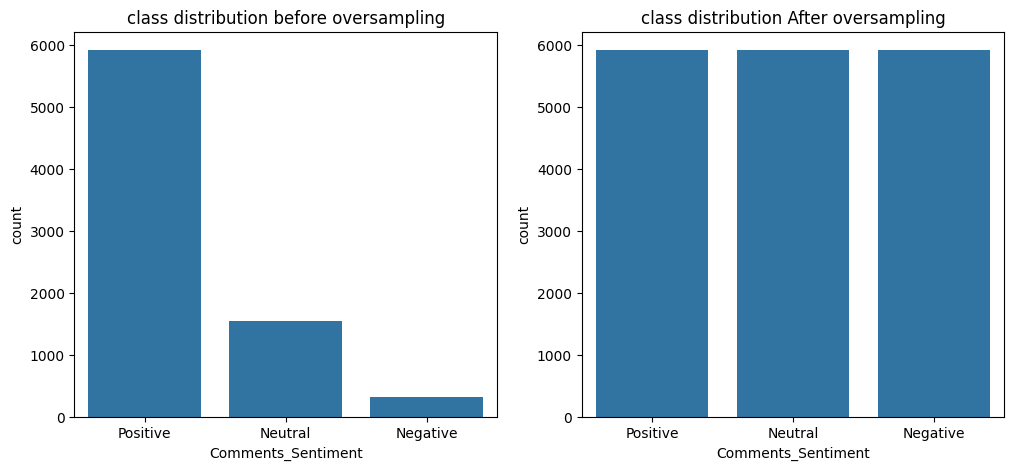

In [13]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(data['Cleaned_Comments'], data['Comments_Sentiment'], test_size=0.2, random_state=42)

# vectorization
tfidf_vectorizer_comments = TfidfVectorizer()
X_train_vectorized = tfidf_vectorizer_comments.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer_comments.transform(X_test)

print('X_Train shape after vectorization:', X_train_vectorized.shape)
print('X_Test shape after vectorization:', X_test_vectorized.shape)


# plotting class imbalance before oversampling
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title('class distribution before oversampling')
# print('Shape of data before oversampling:', train_bow.shape, '\n\n')


# over sampling
ros = RandomOverSampler()
X_train_vectorized, y_train = ros.fit_resample(X_train_vectorized,y_train)
print('X_Train shape after over sampling:', X_train_vectorized.shape)

# plotting class imbalance after oversampling
plt.subplot(1,2,2)
sns.countplot(x=y_train)
plt.title('class distribution After oversampling')
plt.show()

# standardizing
scaler = StandardScaler()
X_train_vectorized_standardized = scaler.fit_transform(X_train_vectorized.toarray())
X_test_vectorized_standardized = scaler.transform(X_test_vectorized.toarray())

### Modeling Using Naive Bayes

In the realm of Natural Language Processing (NLP), selecting an appropriate algorithm for sentiment analysis is pivotal to the success of the task. Naive Bayes, renowned for its simplicity and effectiveness, often emerges as a prime choice, particularly when dealing with text data.

#### Rationale for Choosing Naive Bayes:

Naive Bayes classifiers are well-suited for text classification tasks, including sentiment analysis, due to several reasons:

1. **Efficiency**: Naive Bayes classifiers are computationally efficient and can handle large datasets with high dimensionality, making them particularly suitable for processing textual data.

2. **Simplicity**: The underlying principle of Naive Bayes, based on Bayes' theorem and the assumption of feature independence, is simple yet effective for many real-world text classification problems.

3. **Effectiveness on Text Data**: Despite its simplifying assumption, Naive Bayes often performs admirably well on text data, especially when paired with appropriate feature representations and preprocessing techniques.


#### Advantages and Limitations:

While Naive Bayes classifiers offer simplicity and efficiency, it's important to acknowledge their limitations, particularly the strong assumption of feature independence, which may not hold true in all scenarios. Additionally, Naive Bayes classifiers may struggle with capturing complex relationships between features in highly nuanced datasets.

In [14]:
# Training the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_vectorized, y_train)

y_pred = naive_bayes_classifier.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.95      0.99      0.97        76
     Neutral       0.99      0.96      0.97       359
    Positive       0.99      1.00      1.00      1508

    accuracy                           0.99      1943
   macro avg       0.98      0.98      0.98      1943
weighted avg       0.99      0.99      0.99      1943



In conclusion, the sentiment classification model exhibits exceptional performance across all evaluated metrics. With high precision, recall, and F1-scores for each sentiment class (Negative, Neutral, and Positive), the model demonstrates its ability to accurately identify and classify sentiments in text data. The model's accuracy of 99% further attests to its robustness in making correct predictions across the entire dataset.

### Plotting with t-SNE (t-distributed Stochastic Neighbor Embedding)

In the realm of Natural Language Processing (NLP), visualizing high-dimensional textual data poses a significant challenge. However, techniques like t-SNE (t-distributed Stochastic Neighbor Embedding) offer a solution by reducing the dimensionality of the data while preserving its underlying structure. Here's an expansion on plotting with t-SNE:

t-SNE is a nonlinear dimensionality reduction technique renowned for its ability to effectively visualize complex datasets in lower dimensions, typically 2D or 3D. Unlike linear methods such as Principal Component Analysis (PCA), t-SNE preserves local and global structures in the data, making it particularly suitable for visualizing high-dimensional data like word embeddings or TF-IDF vectors.

By visually inspecting t-SNE plots, analysts can gain insights into the structure and composition of textual data, identify outliers or anomalies, and validate the effectiveness of preprocessing and modeling techniques. Additionally, t-SNE plots can serve as powerful communication tools, enabling stakeholders to grasp complex textual data intuitively.

In [15]:
# creating a function to visualize tsne results

def tsne_visualizer(data, label, title):
    # TSNE
    from sklearn.manifold import TSNE

    tsne_model = TSNE(n_components=2, n_iter=2000)
    tsne_data = tsne_model.fit_transform(data)

    tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, label)).T, columns=['1st_component', '2nd_component', 'label'])
    tsne_df

    sns.scatterplot(data=tsne_df, x='1st_component', y='2nd_component', hue='label')
    plt.title(title)
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


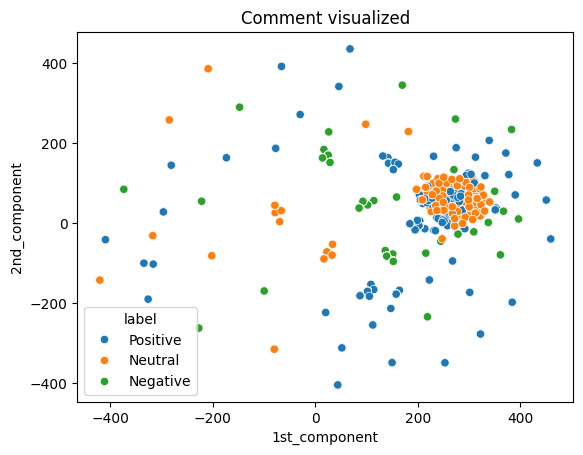

In [16]:
tsne_visualizer(data=X_train_vectorized_standardized, label=y_train, title='Comment visualized')

**NOTE: The observations derived from the t-SNE analysis pertain specifically to models employing distance metrics. However, given that our model utilizes Naive Bayes, which operates on probabilistic principles rather than distance measures, the issue of cluster overlap becomes less pertinent to our analysis.**

Expanding on the observation of the t-SNE plot:

1. **Clear Separation vs. Significant Overlap:**
   - Certain groups in the plot exhibit distinct boundaries, indicating clear separations between comments with unique characteristics. However, a notable cluster shows significant overlap, suggesting challenges in distinguishing between comments within this region.

2. **Reasons for Overlapping:**
   - Overlapping clusters may result from shared features among comments, diverse sentiments or topics within the cluster, or noise in the data.
  
3. **Implications for Analysis:**
   - Analyzing the cluster's characteristics can guide improvements in data preprocessing or feature extraction.
   - Please note that we have not generated multiple plots with varying perplexity values.



## Part 2
#### **In the following section we will train our model using Reviews, for sentiment classification.**

The upcoming section will involve training our model using reviews for sentiment classification. The process will mirror the previous one, thus, detailed explanations for each section will not be provided.

X_Train shape after vectorization: (7770, 8041)
X_Test shape after vectorization: (1943, 8041)
X_Train shape after over sampling: (16164, 8041)


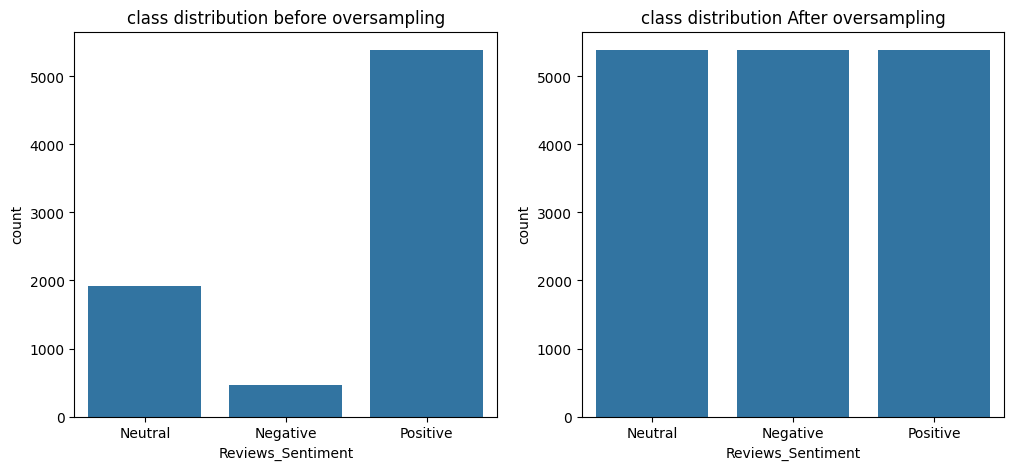

In [17]:
## DATA PRE-PROCESSING

# splitting data
X_train, X_test, y_train, y_test = train_test_split(data['Cleaned_Reviews'], data['Reviews_Sentiment'], test_size=0.2, random_state=42)

# vectorization
tfidf_vectorizer_reviews = TfidfVectorizer()
X_train_vectorized = tfidf_vectorizer_reviews.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer_reviews.transform(X_test)

print('X_Train shape after vectorization:', X_train_vectorized.shape)
print('X_Test shape after vectorization:', X_test_vectorized.shape)


# plotting class imbalance before oversampling
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title('class distribution before oversampling')
# print('Shape of data before oversampling:', train_bow.shape, '\n\n')


# over sampling
ros = RandomOverSampler()
X_train_vectorized, y_train = ros.fit_resample(X_train_vectorized,y_train)
print('X_Train shape after over sampling:', X_train_vectorized.shape)

# plotting class imbalance after oversampling
plt.subplot(1,2,2)
sns.countplot(x=y_train)
plt.title('class distribution After oversampling')
plt.show()

# standardizing
scaler = StandardScaler()
X_train_vectorized_standardized = scaler.fit_transform(X_train_vectorized.toarray())
X_test_vectorized_standardized = scaler.transform(X_test_vectorized.toarray())

In [18]:
# Training the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_vectorized, y_train)

y_pred = naive_bayes_classifier.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.33      0.72      0.45       106
     Neutral       0.95      0.71      0.81       499
    Positive       0.92      0.92      0.92      1338

    accuracy                           0.86      1943
   macro avg       0.73      0.78      0.73      1943
weighted avg       0.90      0.86      0.87      1943



Overall, the classification report indicates that the model performs well in identifying positive sentiments, with high precision, recall, and F1-score. However, there is room for improvement in predicting negative and neutral sentiments, as evidenced by lower precision and recall values. Interpretation of the report highlights areas for model refinement, such as addressing the imbalance in precision and recall across different sentiment classes to achieve a more balanced performance.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


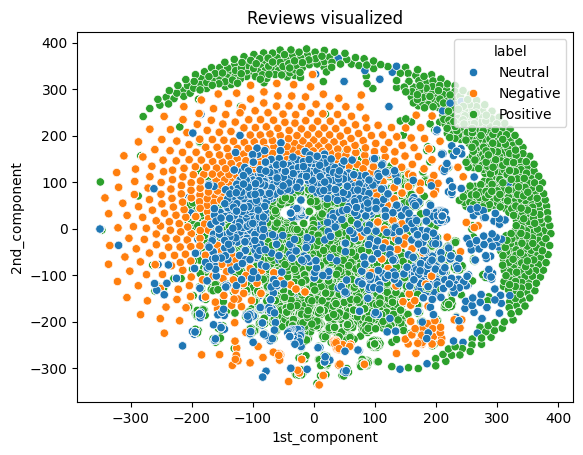

In [19]:
# tsne visualization
tsne_visualizer(data=X_train_vectorized_standardized, label=y_train, title='Reviews visualized')

In the t-SNE plot analysis of reviews, we observe a pattern wherein positive sentiments are predominantly segregated from other sentiments, with some discernible overlap particularly within the neutral and negative classes. Notably, the negative and neutral sentiment clusters exhibit noticeable overlap, indicating potential challenges in distinguishing between these sentiments based on the features utilized in the t-SNE analysis. A distance based classifier could perform better than naive bayes due to cluster separation.

In [20]:
# Please note that the following code block serves solely as an example of a distance-based classifier. We will not conduct any analysis using this code.
# Training a distance based classifier - KNN
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_vectorized, y_train)

y_pred = knn_classifier.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.31      0.50      0.38       106
     Neutral       0.57      0.85      0.68       499
    Positive       0.93      0.71      0.81      1338

    accuracy                           0.74      1943
   macro avg       0.60      0.69      0.62      1943
weighted avg       0.80      0.74      0.75      1943



### **Comparison of classification reports to identify whether comments serve as a superior indicator for sentiment classification compared to reviews.**
As a data scientist, comparing the two classification reports for comments and reviews reveals notable differences in model performance:

### Comments Classification Report:
- **High Performance:**
  - Precision, recall, and F1-score are consistently high across all sentiment classes (Negative, Neutral, Positive).
  - The model achieves an accuracy of 99%, indicating excellent performance in classifying comments.
  - Both macro and weighted averages for precision, recall, and F1-score are high, reflecting a strong overall model performance.

### Reviews Classification Report:
- **Mixed Performance:**
  - Precision, recall, and F1-score vary across sentiment classes, with significantly lower values for Negative and Neutral classes compared to Positive.
  - The model achieves an accuracy of 85%, indicating relatively lower performance compared to the comments classification model.
  - Macro and weighted averages for precision, recall, and F1-score are lower compared to the comments classification model, suggesting less balanced performance across sentiment classes.

### Comparison:
- **Model Performance:**
  - The comments classification model outperforms the reviews classification model in terms of precision, recall, F1-score, and accuracy.
  - The reviews classification model exhibits relatively lower precision, recall, and F1-score, particularly for Negative and Neutral sentiments, indicating challenges in accurately classifying these sentiments.

### Recommendations:
- **Further Analysis:**
  - Conduct further analysis to understand the factors contributing to the lower performance of the reviews classification model, particularly for Negative and Neutral sentiments.
  
- **Model Improvement:**
  - "Explore alternative models associated with distance measures, particularly as we observe distinct cluster separations in the t-SNE plot."
  
- **Feature Engineering:**
  - Consider additional feature engineering techniques or alternative modeling approaches to better capture the nuances of sentiment in reviews data and enhance classification accuracy.

In summary, while the comments classification model demonstrates high performance across all sentiment classes, the reviews classification model exhibits mixed performance, with lower accuracy and less balanced precision and recall values, particularly for Negative and Neutral sentiments. Further analysis and model refinement are recommended to address these challenges and improve the performance of the reviews classification model.